In [1]:
import torchvision
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import random

train_set = torchvision.datasets.FashionMNIST(root = ".", train=True,
download=True, transform=transforms.ToTensor())
test_set = torchvision.datasets.FashionMNIST(root = ".", train=False,
download=True, transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=False)

# fix the seed to be able to get the same randomness across runs and hence reproducible outcomes
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)
# if you are using CuDNN , otherwise you can just ignore
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic=True
torch.backends.cudnn.benchmark=False

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw



Label is: 8
Dimension of input data: torch.Size([32, 1, 28, 28])
Dimension of labels: torch.Size([32])


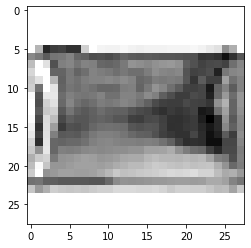

In [27]:
input_data, label = next(iter(train_loader))
plt.imshow(input_data[0,:,:,:].numpy().reshape(28,28), cmap="gray_r");
print("Label is: {}".format(label[0]))
print("Dimension of input data: {}".format(input_data.size()))
print("Dimension of labels: {}".format(label.size()))

In [25]:
class MyCNN(nn.Module):
  def __init__(self):
    super(MyCNN, self).__init__()
    # Parameters to input to nn.Conv2d as specified in the task
    # 1: number of input channels (1 for the images of the FashionMNIST dataset)
    # 2: number of output channels
    # 3: kernel dimensionality (1 dimension if both dimensions are the same)
    # 4: stride dimensionality (1 dimension if both dimensions are the same)

    # Parameters to input to nn.MaxPool2d as specified in the task
    # 1: kernel dimensionality (1 dimension if both dimensions are the same)
    # 2: stride dimensionality (1 dimension if both dimensions are the same)

    # Parameters to input to nn.Conv2d
    # 1: the first input parameter specifies the number of output channels from 
    

    self.cnn_model = nn.Sequential
    (
        nn.Conv2d(1, 12, kernel_size = 3, stride=1),
         nn.ELU(), nn.MaxPool2d(2, stride=2),
          nn.Conv2d(12, 26, kernel_size = 3,stride = 1),
            nn.ELU(), 
              nn.MaxPool2d(2, stride = 2)
                     )
    
    # Parameters to input to nn.Linear
    # 1: last output dimension of the previous layer
    # Note: if previous layer is a CNN or a MaxPool layer the dimension is the one of the flattened output
    # Note: we keep the batch_size dimension constant in the network
    # for example, 32 x 5 x 5 x 26 (batch_size x (5 x 5 x 26) feature matrix) -> 32 x 650 (5*5*26)
    # 2: output dimension
    # dropout is applied after the activation

    
    # alternatively use the Sequential container to run layers sequentially
    self.fc_model = nn.Sequential(
        nn.Linear(650, 650),
         nn.ELU(),
          nn.Dropout(0.5),
           nn.Linear(650,256),
            nn.ELU(),
             nn.Dropout(0.5),
              nn.Linear(256, 10)
              )
 
   
  def forward(self, x):
    
    # pass input via the CNN layers
    x = self.cnn_model(x)
    # we reshape the tensor
    # we keep the first dimension (batch_size)
    # we let Pytorch compute the second dimension 
    # (-1 means compute this dimension given the others)
    x =x.view(x.size(0), -1)
    # pass input via the fully-connected layers
    x = self.fc_model(x)
    
    return x

In [26]:
def evaluation(dataloader):
  total, correct = 0,0
  # turn on evaluate mode, this de-activates certain modes such as dropout
  # good practice to include in your projects
  net.eval()
  for data in dataloader:
    
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = net(inputs)
    # we take the index of the class that received the highest value  
    # we take outputs.data so that no backpropagation is performed for these outputs
    _, pred = torch.max(outputs.data, 1)
    total += labels.size(0)
    # .item() takes Python float values from the tensor
    correct += (pred == labels).sum().item()
  return 100 * correct / total

In [5]:
def weights_init(m):
    # initialise both linear and convolutional layers
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        torch.nn.init.xavier_normal_(m.weight)

In [7]:
device = torch.device("cuda:0")

alpha = 0.1

net = MyCNN().to(device)
# initialise weights
net.apply(weights_init)

# Note: CrossEntropy loss is usually used for classification tasks
# check slide 25 of Lecture 8.2
loss_fn = nn.CrossEntropyLoss()
loss_fn.to(device)

# SGD optimiser, learning rate is specified by alpha
opt = torch.optim.Adam(list(net.parameters()), lr=alpha)
    
loss_epoch_array = []
max_epochs = 5
loss_epoch = 0
train_accuracy = []
test_accuracy = []
# loop over epochs
for epoch in range(max_epochs):
  # we will compute sum of batch losses per epoch
  loss_epoch = 0
  # loop over batches
  for i, data in enumerate(train_loader, 0):
    # to ensure the training mode is "turned on"
    net.train()
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    # zero the gradients
    opt.zero_grad()
    outputs = net(inputs)
    # compute the loss
    loss = loss_fn(outputs, labels)
    # calculate the gradients
    loss.backward()
    # update the parameters using the gradients and optimizer algorithm 
    opt.step()
    # we sum the loss over batches
    loss_epoch += loss.item()
  
  loss_epoch_array.append(loss_epoch)
  train_accuracy.append(evaluation(train_loader))
  test_accuracy.append(evaluation(test_loader))
  print("Epoch {}: loss: {}, train accuracy: {}, valid accuracy:{}".format(epoch + 1, loss_epoch_array[-1], train_accuracy[-1], test_accuracy[-1]))

Epoch 1: loss: 978.64238820225, train accuracy: 85.56, valid accuracy:83.97
Epoch 2: loss: 732.4620133265853, train accuracy: 88.54, valid accuracy:86.91
Epoch 3: loss: 666.4676813669503, train accuracy: 89.34833333333333, valid accuracy:87.73
Epoch 4: loss: 620.8506184890866, train accuracy: 89.385, valid accuracy:87.46
Epoch 5: loss: 594.5827535353601, train accuracy: 90.00833333333334, valid accuracy:87.89
Epoch 6: loss: 577.158878274262, train accuracy: 90.47333333333333, valid accuracy:88.23
Epoch 7: loss: 561.9145354107022, train accuracy: 91.07666666666667, valid accuracy:88.46
Epoch 8: loss: 548.4372614696622, train accuracy: 90.985, valid accuracy:88.71
Epoch 9: loss: 537.709724733606, train accuracy: 91.79, valid accuracy:88.56
Epoch 10: loss: 530.1520299781114, train accuracy: 91.93833333333333, valid accuracy:88.77


In [19]:
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in net.state_dict():
    print(param_tensor, "\t", net.state_dict()[param_tensor].size())

# # Print optimizer's state_dict
# print("Optimizer's state_dict:")
# for var_name in opt.state_dict():
#     print(var_name, "\t", opt.state_dict()[var_name])

Model's state_dict:
cnn_model.0.weight 	 torch.Size([12, 1, 3, 3])
cnn_model.0.bias 	 torch.Size([12])
cnn_model.3.weight 	 torch.Size([26, 12, 3, 3])
cnn_model.3.bias 	 torch.Size([26])
fc_model.0.weight 	 torch.Size([650, 650])
fc_model.0.bias 	 torch.Size([650])
fc_model.3.weight 	 torch.Size([256, 650])
fc_model.3.bias 	 torch.Size([256])
fc_model.6.weight 	 torch.Size([10, 256])
fc_model.6.bias 	 torch.Size([10])


In [23]:
torch.save(net.state_dict(), '/content/model1.pt')

In [24]:
model = MyCNN()
model.load_state_dict(torch.load('/content/model1.pt'))
model.eval()

MyCNN(
  (cnn_model): Sequential(
    (0): Conv2d(1, 12, kernel_size=(3, 3), stride=(1, 1))
    (1): ELU(alpha=1.0)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(12, 26, kernel_size=(3, 3), stride=(1, 1))
    (4): ELU(alpha=1.0)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_model): Sequential(
    (0): Linear(in_features=650, out_features=650, bias=True)
    (1): ELU(alpha=1.0)
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=650, out_features=256, bias=True)
    (4): ELU(alpha=1.0)
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=256, out_features=10, bias=True)
  )
)